![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [150]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Import any additional modules and start coding below
#print(os.getcwd())

#Import Dataset
df = pd.read_csv('/work/files/workspace/rental_info.csv', parse_dates=['return_date', 'rental_date'])

#Create the target feature
df['rental_lenght_days'] = df['return_date']-df['rental_date']
df['rental_lenght_days'] = (df['rental_lenght_days'].astype(int) // 10**9) // (24*3600)

#Feature engineering
df['deleted_scenes'] = df['special_features'].apply(lambda x: 1 if 'Deleted Scene' in x else 0)
df['behind_the_scenes'] = df['special_features'].apply(lambda x: 1 if 'Behind the Scenes' in x else 0)




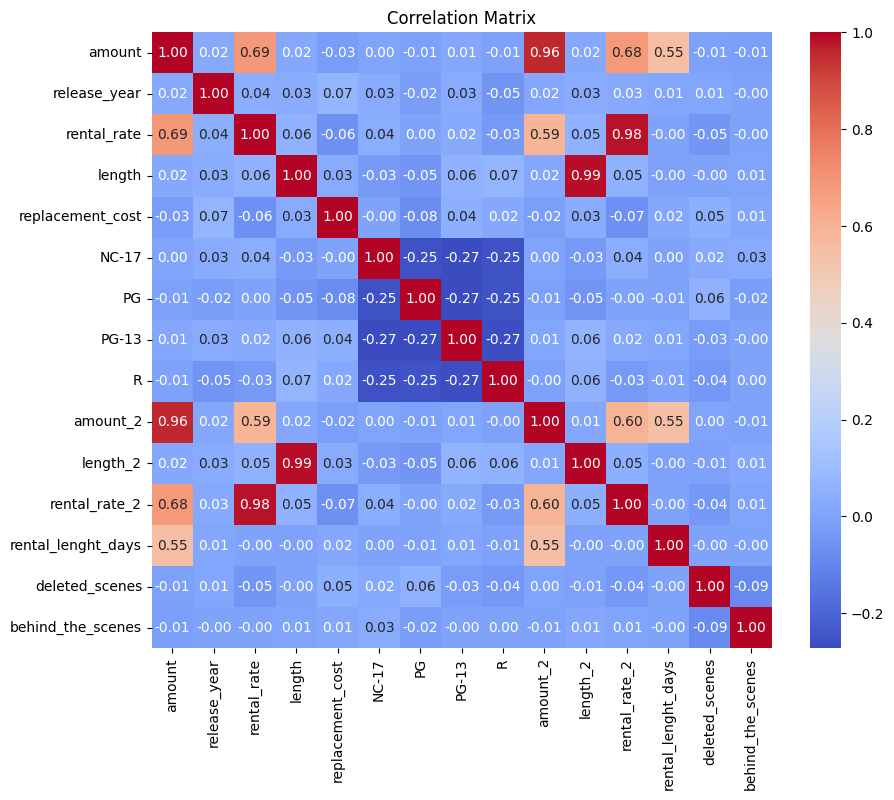

In [151]:
# Check for corretalions between variables

correlation_matrix = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [152]:
#Plot pairplot
#numerical_cols= df.select_dtypes(include=['float64', 'int64']).columns
#sns.pairplot(df[numerical_cols])
#plt.title('Pairplot')
#plt.show()


In [153]:
# Divide X-y features
X = df.drop(['rental_lenght_days', 'return_date', 'rental_date', 'special_features'], axis=1)
y = df['rental_lenght_days']

print(X.shape, y.shape)

(15861, 14) (15861,)


In [154]:
#Split data for train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=9)

In [155]:
# pre-processing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [156]:
#Import ML models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [157]:
#Evaluation of diferent models to select the best performers

#models= {
    #'knn': KNeighborsRegressor(), #n_neighbors,
    #'svm': SVR(kernel='rbf'),
    #'xgb': xgb.XGBRegressor(objective='reg:linear', seed=9), #n_estimators, max_detph,
    #'rfr':RandomForestRegressor() #n_estimators, max_depth,
    #'dbr': GradientBoostingRegressor() #n_estimators, max_depth
#}
#results = []

#for model in models.values():
#    cv_scores= cross_val_score(model, x_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
#    results.append(abs(cv_scores))

#plt.boxplot(results, labels=models.keys())
#plt.show()

#print('Best model XGB result MSE:',np.mean(results[2]))
#print('RSME:', (np.mean(results[2]))**(1/2))

In [159]:
#Hypertunning XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

param_grid = {
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
rf_search = RandomizedSearchCV(rf, param_distributions=param_grid, cv=5, n_iter=2, random_state=9, scoring='neg_mean_squared_error')

# Fit the estimator
randomized_MSE.fit(x_train_scaled, y_train)

best_params = randomized_MSE.best_params_

# Compute metrics
print(randomized_MSE.best_score_)
print(randomized_MSE.best_estimator_)

Fitting 2 folds for each of 21 candidates, totalling 42 fits
[21:01:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:39] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:s

In [160]:
# Train, predict, evaluate tunned xgb model

rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=9)

rf.fit(x_train_scaled, y_train)

y_pred = rf.predict(x_test_scaled)

best_model = rf
best_mse = mean_squared_error(y_test, y_pred)

print('MSE RF model:', best_mse)
print('RSME:', best_mse**(1/2))

MSE RF model: 2.4905879025340276
RSME: 1.578159656857958
